## Convocatoria 1 - Proyecto 1

José Luis Calvo

In [2]:
# IMPORTS
import math

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io
from skimage import morphology
from scipy import ndimage
from skimage.measure import label
from skimage.measure import regionprops

#### 0) Cargar una de las imágenes histológicas

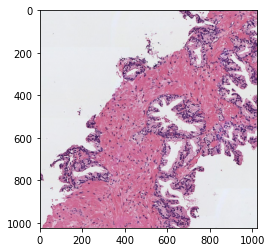

In [3]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
#Imagen 1
histo_1 = 'histo_1.jpg'

#Imagen 2
histo_2 = 'histo_2.jpg'

#Lectura
rgb = io.imread(histo_1)

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
rgb_norm = rgb.astype('uint8')/255

# Visualizar la imagen
plt.imshow(rgb_norm, cmap='gray')
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

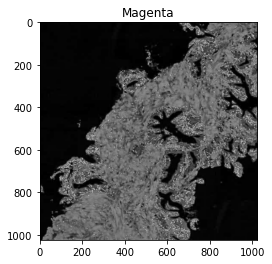

In [4]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(rgb_norm, axis=2)    # valor de K (negro)
    C = (1-rgb_norm[:,:,0] - K)/(1-K)   # valor de C en cada píxel
    M = (1-rgb_norm[:,:,1] - K)/(1-K)   # valor de M
    Y = (1-rgb_norm[:,:,2] - K)/(1-K)   # valor de Y

CMYK = (np.dstack((C,M,Y,K)) * 255).astype('uint8')

# Visualizar la imagen del canal magenta
C,M,Y,K = cv2.split(CMYK)

plt.imshow(M, cmap='gray')
plt.title('Magenta')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

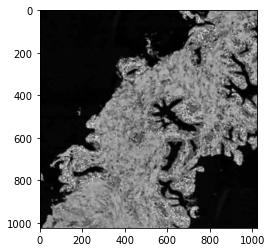

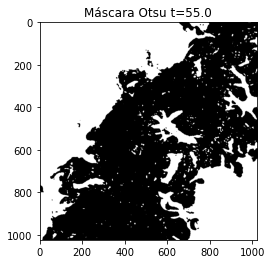

In [5]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

#Desenfoque Gaussiano
img_gaus = cv2.GaussianBlur(M, (5,5), 4) # (5x5) es el tamaño del filtro y 0 es la desviación estándar

plt.imshow(img_gaus, cmap='gray')
plt.show()

#Otsu
#Inversion binaria para cumplir con el enunciado
t, mask = cv2.threshold(img_gaus,0,1,cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)

plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

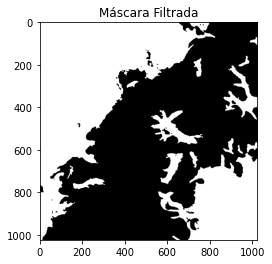

In [6]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects

# mask es el resultado del apartado anterior
max_filtered = morphology.remove_small_objects(mask.astype('bool'), min_size = 300).astype('uint8')

# Visualizar la máscara resultante
plt.imshow(max_filtered, cmap='gray')
plt.title('Máscara Filtrada')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

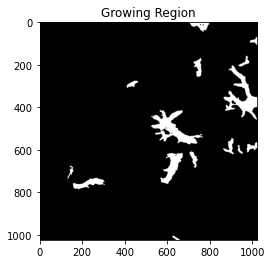

In [7]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
mask = max_filtered.copy()

def growing_region(image, seed):
    h, w = image.shape
    ref = np.zeros((h+2, w+2), np.uint8)
    boundaries = np.array([image[0,:], image[:,0], image[-1,:], image[:,-1]])
    for position, boundary in enumerate(boundaries):
        for pixel in range(len(boundary)):
            if position == 0:
                x = 0
                y = pixel
            if position == 1:
                x = pixel
                y = 0
            if position == 2:
                x = h-1
                y = pixel
            if position == 3:
                x = pixel
                y = w-1
            if image[x,y] == 1:
                cv2.floodFill(image, ref, (x,y), seed)
    return image

#La función se aplica sobre una copia del resultado del apartado anterior
mask_filled = growing_region(mask, 0)

##### Visualizar la máscara resultante
plt.imshow(mask_filled, cmap='gray')
plt.title('Growing Region')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

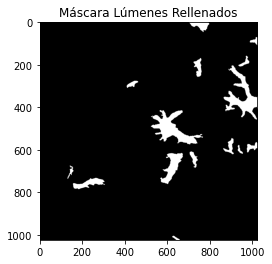

In [8]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
mask_filled_cleaned = ndimage.binary_fill_holes(mask_filled).astype('uint8')

# Visualizar la máscara resultante
plt.imshow(mask_filled_cleaned, cmap='gray')
plt.title('Máscara Lúmenes Rellenados')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

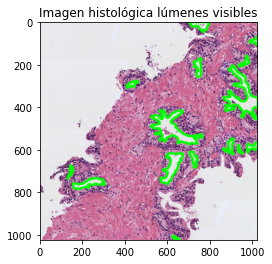

In [9]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.

# Se identifica cada objeto para acceder a él posteriormente
labels, num = label(mask_filled_cleaned, return_num=True)

# Copia de la imagen original (rgb)
image = rgb.copy()

# Iterar sobre cada objeto identificado
for i in range(1, num+1):
    objeto = labels == i
    objeto = objeto.astype('uint8')
    
    conts, _ = cv2.findContours(objeto, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image = cv2.drawContours(image, conts, -1, (0,255,0), 10)

# Visualizar la imagen superpuesta
plt.imshow(image, cmap='gray')
plt.title('Imagen histológica lúmenes visibles')
plt.show()

#### 7) Identificar y cropear el lumen más grande

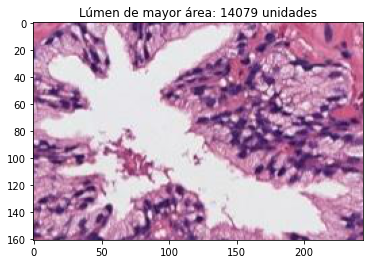

In [10]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
label_biggest_lumen = 0
area = 0

for i in range(1, num+1):
    objeto = labels == i
    objeto = objeto.astype('uint8')
    
    propiedades = regionprops(objeto)

    if propiedades[0].area > area:
        area = propiedades[0].area
        label_biggest_lumen = objeto

# Visualizar el lumen cropeado.
bbox = regionprops(label_biggest_lumen)[0].bbox

# Imgen original: rgb
imagen = rgb.copy()
# crop usando slicing
biggest_lumen = imagen[bbox[0]:bbox[2], bbox[1]:bbox[3]]

plt.imshow(biggest_lumen, cmap='gray')
plt.title(f'Lúmen de mayor área: {area} unidades')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [11]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

props = regionprops(label_biggest_lumen)[0]
round_to = 4

dict_props = {
    'Área': np.round(props.area, round_to),                         
    'Área de la bounding box': np.round(props.area_bbox, round_to),                          
    'Área convexa': np.round(props.area_convex, round_to),                        
    'Exentricidad': np.round(props.eccentricity, round_to),                      
    'Diámetro equivalente': np.round(props.equivalent_diameter_area, round_to),   
    'Extensión': np.round(props.extent, round_to),                                  
    'Diámetro Feret': np.round(props.feret_diameter_max, round_to),          
    'Longitud del eje mayor': np.round(props.axis_major_length, round_to),
    'Longitud del eje menor': np.round(props.axis_minor_length, round_to),
    'Orientación': np.round(props.orientation, round_to),
    'perimeter': np.round(props.perimeter, round_to),
    'Solidez': np.round(props.solidity, round_to),
    'Compacidad': np.round(4*math.pi*props.area/props.perimeter**2, round_to)
}
    
# Serie de pandas para estructurar la informacion
s = pd.Series(dict_props)
display(s)

Área                       14079.0000
Área de la bounding box    39284.0000
Área convexa               29222.0000
Exentricidad                   0.8482
Diámetro equivalente         133.8878
Extensión                      0.3584
Diámetro Feret               262.9449
Longitud del eje mayor       238.8568
Longitud del eje menor       126.4988
Orientación                    1.0045
perimeter                   1225.0763
Solidez                        0.4818
Compacidad                     0.1179
dtype: float64